In [2]:
# Base libraries
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 7)
plt.style.use('fivethirtyeight')

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,
                                     TimeSeriesSplit,
                                     cross_val_score)

# Classifier
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import (precision_recall_curve,
                             roc_curve,
                             RocCurveDisplay,
                             ConfusionMatrixDisplay)
from sklearn.metrics import (accuracy_score,
                             f1_score,
                             recall_score,
                             precision_score,
                             roc_auc_score,
                             auc)
from sklearn.metrics import (classification_report,
                             confusion_matrix)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Load locally stored data
df = pd.read_csv('data/spy.csv', index_col=0, parse_dates=True)

# Check first 5 values
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1928-03-01,17.760000,17.760000,17.760000,17.760000,17.760000,0
1928-04-01,17.719999,17.719999,17.719999,17.719999,17.719999,0
1928-05-01,17.549999,17.549999,17.549999,17.549999,17.549999,0
1928-06-01,17.660000,17.660000,17.660000,17.660000,17.660000,0
1928-09-01,17.500000,17.500000,17.500000,17.500000,17.500000,0


In [6]:
df.shape

(23973, 6)

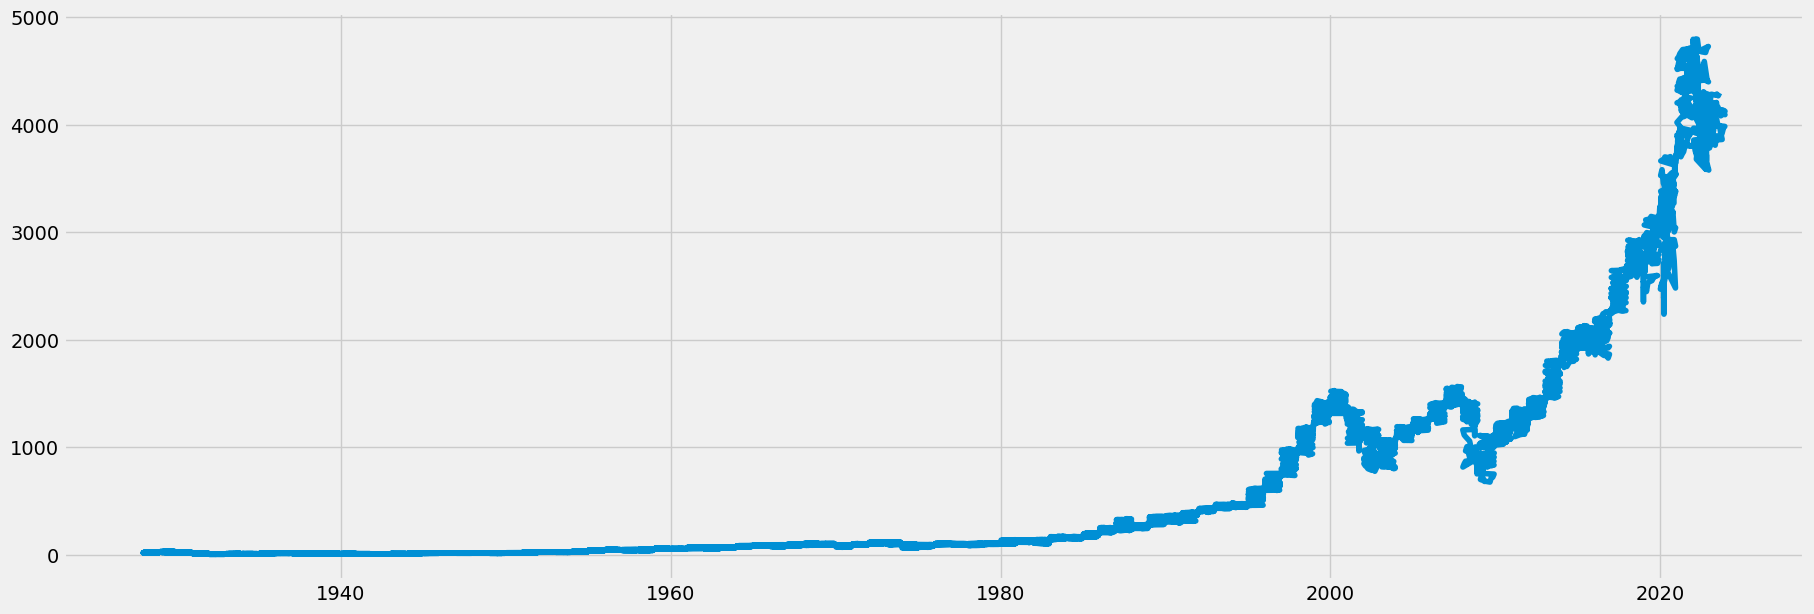

In [7]:
# Visualize data
plt.plot(df['Adj Close'])

In [8]:
# Descriptive statistics
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,23973.000000,23973.000000,23973.000000,23973.000000,23973.000000,2.397300e+04
mean,565.797732,589.355412,582.108859,585.963759,585.963759,8.704260e+08
std,942.221043,936.343254,925.103864,931.085908,931.085908,1.592290e+09
min,0.000000,4.400000,4.400000,4.400000,4.400000,0.000000e+00
25%,9.540000,24.450001,24.450001,24.450001,24.450001,1.440000e+06
50%,40.730000,102.190002,100.610001,101.419998,101.419998,1.919000e+07
75%,963.090027,972.859985,952.669983,963.390015,963.390015,8.173000e+08
max,4804.509766,4818.620117,4780.040039,4796.560059,4796.560059,1.145623e+10


In [9]:
# Check for missing values
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [10]:
# Predictors
df['O-C'] = df.Open - df.Close
df['H-L'] = df.High - df.Low

X = df[['O-C', 'H-L']].values
X

array([[  0.      ,   0.      ],
       [  0.      ,   0.      ],
       [  0.      ,   0.      ],
       ...,
       [-12.510254,  25.240234],
       [ 17.950195,  35.22998 ],
       [-25.240235,  36.939942]])

In [11]:
# Target - Avoid using [-1, 1], always prefer [0, 1] as class labels
y = np.where(df['Adj Close'].shift(-1) > 0.995*df['Adj Close'], 1, -1)
y

array([ 1, -1,  1, ...,  1,  1, -1])

In [12]:
# Value counts for class 1 and -1
pd.Series(y).value_counts()

 1    18324
-1     5649
dtype: int64

In [13]:
# Spliting the datasets into training and testing data
# Always keep shuffle = False for financial time series
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Output the train and test data size
print(f'Train and Test size {len(X_train)}, {len(X_test)}')

Train and Test size 19178, 4795


In [29]:
# Scale and fit the model
model = Pipeline([('Scaler', MinMaxScaler()),
                 ('classifier', KNeighborsClassifier())])
model.fit(X_train, y_train)

Pipeline(steps=[('Scaler', MinMaxScaler()),
                ('classifier', KNeighborsClassifier())])

In [15]:
# Predicting the test dataset
y_pred = model.predict(X_test)

# Predict probabilities
y_proba = model.predict_proba(X_test)

# Verifiy the class labels
model.classes_

array([-1,  1])

In [16]:
# Predict probability
y_proba[-20:]

array([[0.2, 0.8],
       [0.6, 0.4],
       [0.4, 0.6],
       [0.2, 0.8],
       [0. , 1. ],
       [0.2, 0.8],
       [0.6, 0.4],
       [0.6, 0.4],
       [0.4, 0.6],
       [0. , 1. ],
       [0.4, 0.6],
       [0.4, 0.6],
       [0.4, 0.6],
       [0.4, 0.6],
       [0. , 1. ],
       [0.2, 0.8],
       [0.4, 0.6],
       [0.4, 0.6],
       [0. , 1. ],
       [0.2, 0.8]])

In [17]:
# Predict class labels
y_pred[-20:]

array([ 1, -1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1])

In [18]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)

print(f'Train accuracy: {acc_train:0.4}, Test accuracy: {acc_test:0.4}')

Train accuracy: 0.7776, Test accuracy: 0.6905


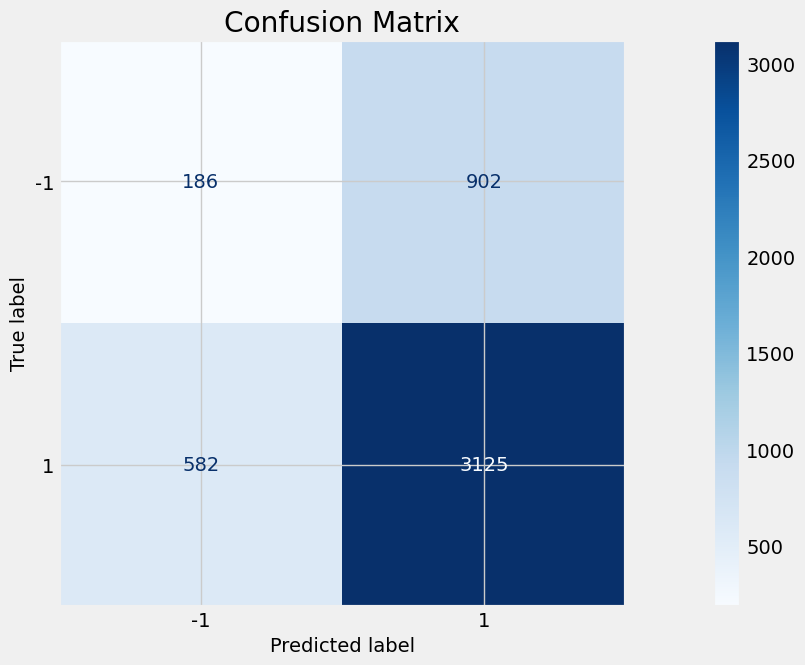

In [19]:
# Display the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(model,
                                             X_test,
                                             y_test,
                                             cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [20]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.24      0.17      0.20      1088
           1       0.78      0.84      0.81      3707

    accuracy                           0.69      4795
   macro avg       0.51      0.51      0.50      4795
weighted avg       0.65      0.69      0.67      4795



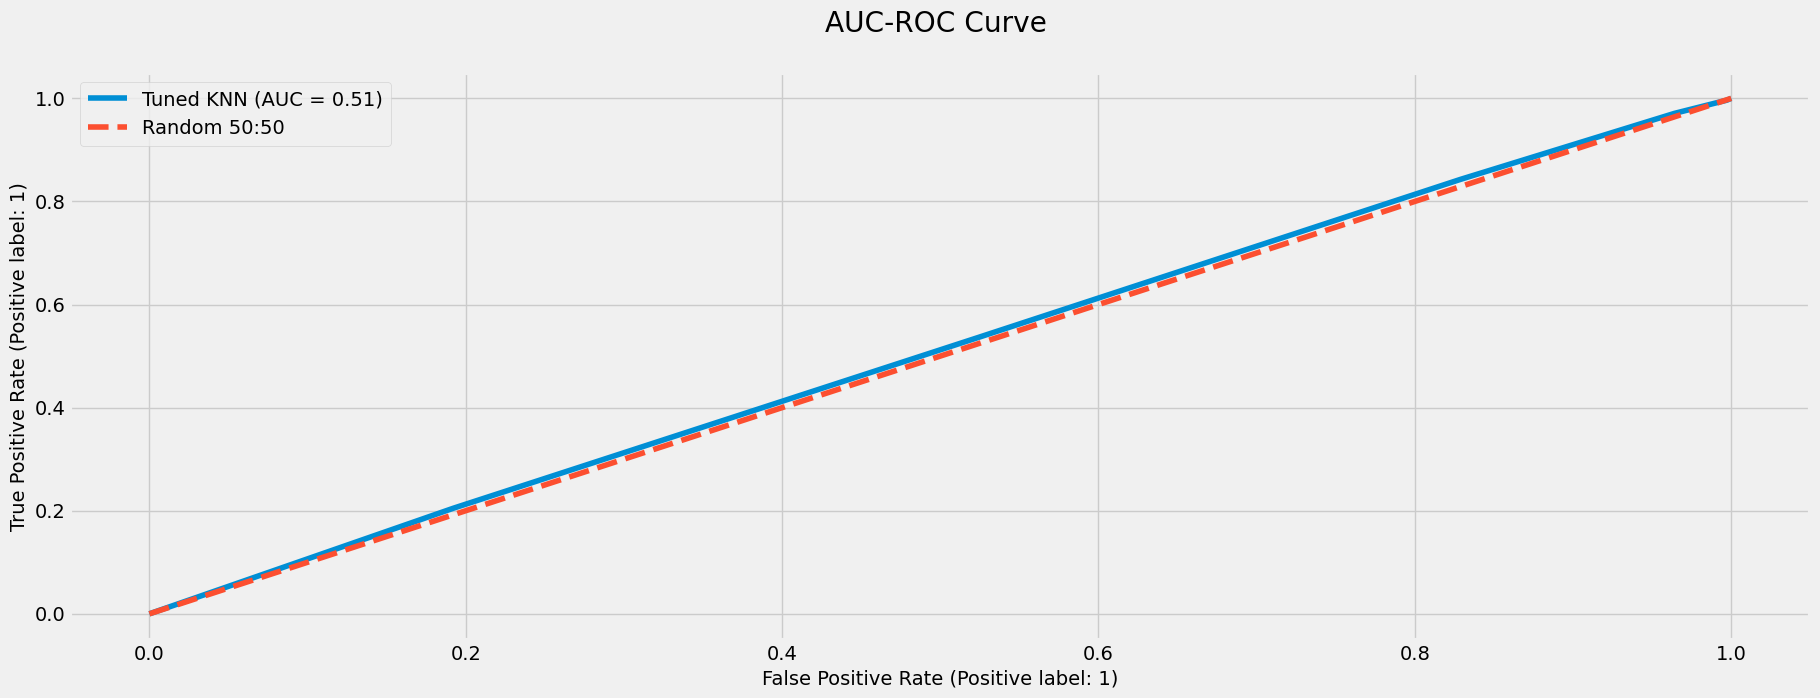

In [21]:
# Display ROC Curve
disp = RocCurveDisplay.from_estimator(model,
                                      X_test,
                                      y_test,
                                      name='Tuned KNN')
plt.title('AUC-ROC Curve \n')
plt.plot([0, 1], 
         [0, 1],
         linestyle='--',
         label='Random 50:50')
plt.legend()
plt.show()

In [23]:
# Example: First 2 split
tscv = TimeSeriesSplit(n_splits=4,
                       gap=1)
for train, test in tscv.split(X):
    print(train, test)

[   0    1    2 ... 4793 4794 4795] [4797 4798 4799 ... 9588 9589 9590]
[   0    1    2 ... 9587 9588 9589] [ 9591  9592  9593 ... 14382 14383 14384]
[    0     1     2 ... 14381 14382 14383] [14385 14386 14387 ... 19176 19177 19178]
[    0     1     2 ... 19175 19176 19177] [19179 19180 19181 ... 23970 23971 23972]


In [24]:
# Cross-validation
tscv = TimeSeriesSplit(n_splits=5,
                       gap=1)

In [27]:
# Get parameters list
model.get_params()

{'memory': None,
 'steps': [('Scaler', MinMaxScaler()), ('Classifier', KNeighborsClassifier())],
 'verbose': False,
 'Scaler': MinMaxScaler(),
 'Classifier': KNeighborsClassifier(),
 'Scaler__clip': False,
 'Scaler__copy': True,
 'Scaler__feature_range': (0, 1),
 'Classifier__algorithm': 'auto',
 'Classifier__leaf_size': 30,
 'Classifier__metric': 'minkowski',
 'Classifier__metric_params': None,
 'Classifier__n_jobs': None,
 'Classifier__n_neighbors': 5,
 'Classifier__p': 2,
 'Classifier__weights': 'uniform'}

In [30]:
# Perform Gridsearch and fit
param_grid = {'classifier__n_neighbors': np.arange(1, 51, 1)}

gs = GridSearchCV(model, param_grid, scoring='roc_auc', n_jobs=1, cv=tscv, verbose=1)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('Scaler', MinMaxScaler()),
                                       ('classifier', KNeighborsClassifier())]),
             n_jobs=1,
             param_grid={'classifier__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
             scoring='roc_auc', verbose=1)

In [32]:
# Best params and scores
print(f'Optimal Neighbors: {gs.best_params_}, Best Score: {round(gs.best_score_, 4)}')

Optimal Neighbors: {'classifier__n_neighbors': 13}, Best Score: 0.5227


In [33]:
# Instantiate KNN model with search param
clf = KNeighborsClassifier(n_neighbors=gs.best_params_['classifier__n_neighbors'])

# Fit the model
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=13)

In [35]:
# Predicting the test dataset
y_pred = clf.predict(X_test)

# Predict probabilities
y_proba = clf.predict_proba(X_test)[:,1]

# Measure accuracy
acc_train = accuracy_score(y_train, clf.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)

# Print accuracy
print(f'\n Training accuracy \t: {acc_train:0.4} \n Test accuracy \t\t: {acc_test:0.4}')


 Training accuracy 	: 0.7634 
 Test accuracy 		: 0.7422


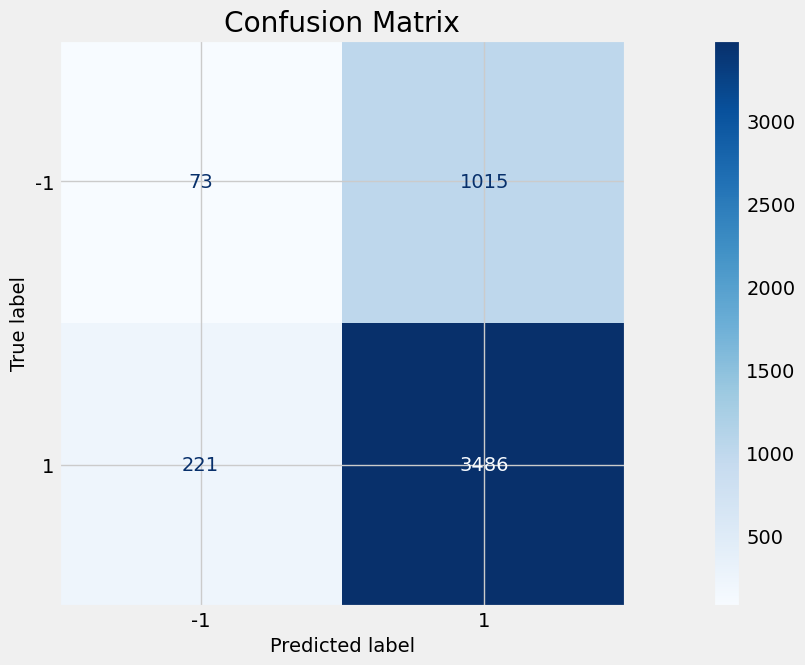

In [36]:
# Display confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(clf,
                                             X_test,
                                             y_test,
                                             display_labels=model.classes_,
                                             cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

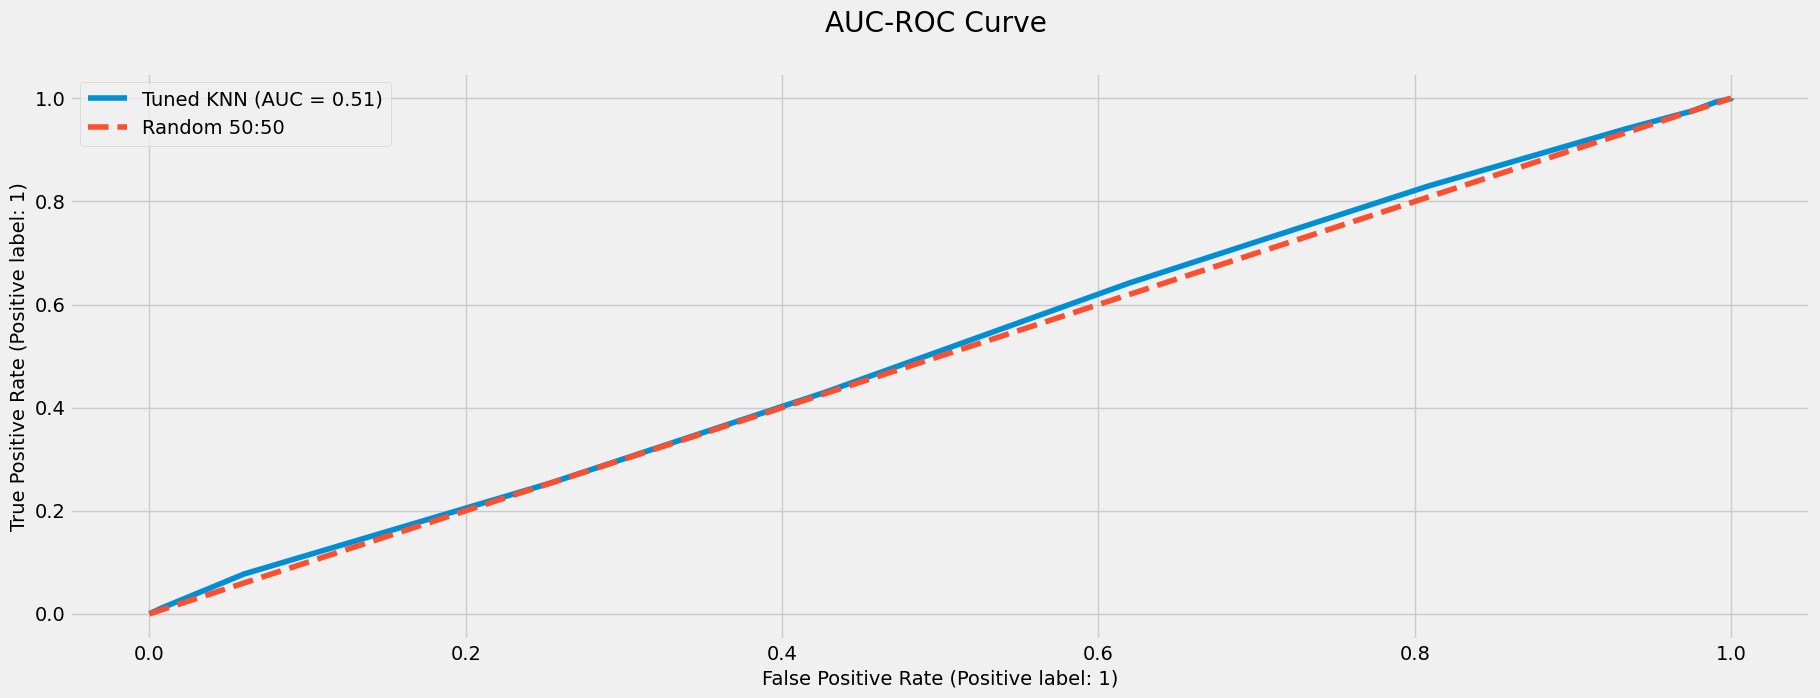

In [37]:
# Display ROC Curve
disp = RocCurveDisplay.from_estimator(clf,
                                      X_test,
                                      y_test,
                                      name='Tuned KNN')
plt.title('AUC-ROC Curve \n')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random 50:50')
plt.legend()
plt.show()

In [38]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.25      0.07      0.11      1088
           1       0.77      0.94      0.85      3707

    accuracy                           0.74      4795
   macro avg       0.51      0.50      0.48      4795
weighted avg       0.66      0.74      0.68      4795

